# Titanic EDA

An EDA for the Titanic data associated with the corresponding competition on Kaggle.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as plt_figure
import pandas as pd
import seaborn as sns
from typing import Optional, List, Tuple, Union, Any, Callable, Set, Dict

import warnings

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na option is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*When grouping with a length-1 list-like.*")

### Data Type Checker

In [2]:
class DataTypeRecognizer:
    def __init__(self, df: pd.DataFrame):
            self.df = df
        
    def check_feature_type(self, column_name: str) -> str:
        unique_values = self.df[column_name].nunique()
        if self.df[column_name].dtype in [np.int64, np.float64]:
            if self.df[column_name].min() >= 0:
                # Assuming if min is >= 0, it might be Ratio
                # Further checks can be applied based on domain knowledge
                return "Ratio"
            else:
                return "Interval"
        elif self.df[column_name].dtype == object:
            # For object types, further analysis is needed to determine if it's nominal or ordinal
            # Here, a simple heuristic based on unique values
            if unique_values < 20:  # Arbitrary threshold for small number of unique values
                return "Ordinal"
            else:
                return "Nominal"
        else:
            return "Unknown"
    
    def check_all_features(self):
        feature_types = {}
        for column in self.df.columns:
            feature_types[column] = self.check_feature_type(column)
        return feature_types
    
    def display_feature_types(self):
        feature_types = self.check_all_features()
        for column, f_type in feature_types.items():
            print(f"{column}: {f_type}")

### Missing Values Handlers

In [3]:
# A class for filling missing values
class MissingValueFiller:
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def fill_missing_values(self, column_name: str, strategy: str, return_column: bool = False) -> Optional[pd.Series]:
        if strategy == "mean":
            self.column_name = self.df[column_name].fillna(self.df[column_name].mean())
        elif strategy == "median":
            self.column_name = self.df[column_name].fillna(self.df[column_name].median())
        elif strategy == "mode":
            self.column_name = self.df[column_name].fillna(self.df[column_name].mode()[0])
        elif strategy == 'custom_value':
            custom_value = input("Enter the custom value: ")
            self.column_name = self.df[column_name].fillna(custom_value)
        else:
            raise ValueError("Invalid strategy")
        
        if return_column:
            return self.df[column_name]
    
    def fill_missing_values_all_features(self, columns: Union[str, list[str]], strategy: str, return_columns: bool = False) -> Optional[pd.DataFrame]:
        for column in columns:
            if self.df[column].isnull().sum() > 0:
                self.fill_missing_values(column, strategy)
                
        if return_columns:
            return self.df

In [4]:
# A class for handling missing values that uses the MissingValueFiller class
class MissingValueHandler:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.missing_value_filler = MissingValueFiller(df)
    
    def fill_missing_values(self, strategy: str, return_columns: bool = False) -> Optional[pd.DataFrame]:
        return self.missing_value_filler.fill_missing_values_all_features(strategy, return_columns)
    
    def fill_missing_values_by_feature(self, column_name: str, strategy: str, return_column: bool = False) -> Optional[pd.Series]:
        return self.missing_value_filler.fill_missing_values(column_name, strategy, return_column)
    
    def drop_missing_values(self, columns: Union[str, list[str]], return_df: bool = False) -> Optional[pd.DataFrame]:
        self.df.dropna(subset=columns, inplace=True)
        if return_df:
            return self.df
    
    # A function to dispaly the missing values for each feature in a new dataframe that includes both amount and percentage of missing values
    def display_missing_values(self):
        missing_values = self.df.isnull().sum()
        missing_values_percent = round((self.df.isnull().sum() / self.df.shape[0]) * 100, 3)
        missing_values_df = pd.concat([missing_values, missing_values_percent], axis=1)
        missing_values_df.columns = ["Missing Values", "Percentage(%)"]
        return missing_values_df
    
    # A function that displays the number of data points
    def display_data_points(self):
        return f'Number of Data Points in Dataset: {self.df.shape[0]}'    

#### Feature Display

In [5]:
# A class for displaying features in the dataset using seaborn
class FeatureVisualizer:
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def display_feature_distribution(self, column_name: str, plot_type: str = "hist", bins: Optional[int] = 20):
        if plot_type == "hist":
            sns.histplot(self.df[column_name], bins=bins)
        elif plot_type == "box":
            sns.boxplot(self.df[column_name])
        else:
            raise ValueError("Invalid plot type")
            
    # A function to get the numerical features in the dataset
    def get_numerical_features(self) -> List[str]:
        return self.df.select_dtypes(include=[np.number]).columns.tolist()
    
    # A function to get the categorical features in the dataset
    def get_categorical_features(self) -> List[str]:
        return self.df.select_dtypes(include=[object]).columns.tolist()
            
    # A function to display the correlation between features in the dataset using a heatmap that shows the correlation values in each cell
    def display_correlation(self, columns: List[str]):
        # Check if columns are in the dataframe
        if not all(col in self.df.columns for col in columns):
            raise ValueError("Some columns are not in the DataFrame")
        
        # Calculate the correlation matrix and handle NaN values
        correlation_matrix = self.df[columns].corr().fillna(0)
        
        # Set up the matplotlib figure
        plt.figure(figsize=(10, 8))
        
        # Create the heatmap with detailed configurations
        heatmap = sns.heatmap(
            correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap="Reds",
            cbar=True,
            annot_kws={"size": 10},
            linewidths=0.5,  # Add lines between boxes for better separation
            linecolor='gray',  # Color of the lines between boxes
            vmin=-1,  # Minimum value for the colormap
            vmax=1  # Maximum value for the colormap
        )
        
        # Set the title and adjust layout
        plt.title("Correlation Heatmap")
        plt.tight_layout()  # Adjust layout to ensure everything fits
        plt.show()
        
    # A function to display the relationship between features
    def display_relationship(self, x: str, y: str):
        sns.scatterplot(x=x, y=y, data=self.df)
        
    # A function to display the relationship between features with hue
    def display_relationship_with_hue(self, x: str, y: str, hue: str):
        sns.scatterplot(x=x, y=y, hue=hue, data=self.df)
    
    # A function to display the relationship between features with hue and style
    def display_relationship_with_hue_and_style(self, x: str, y: str, hue: str, style: str):
        sns.scatterplot(x=x, y=y, hue=hue, style=style, data=self.df)
    
    # A function to display multiple subplots using the display_feature_distribution function above. Display 3 subplots per row
    def display_multiple_distribution_subplots(self, columns: list[str], plot_type: str = "hist", bins: Optional[int] = 20):
        rows = len(columns) // 3
        
        fig, axs = plt.subplots(rows, 3, figsize=(20, 5 * rows))
        
        row_index = 0
        col_index = 0
        for column in columns:
            if plot_type == "hist":
                axs[row_index, col_index].set_title(f'Distribution of {column}')
                axs[row_index, col_index].hist(self.df[column], bins=bins)
            elif plot_type == "box":
                axs[row_index, col_index].set_title(f'Boxplot of {column}')
                axs[row_index, col_index].boxplot(self.df[column])
            else:
                raise ValueError("Invalid plot type")
                
            col_index += 1
            if col_index == 3:
                row_index += 1
                col_index = 0

### Exploratory Data Analysis

#### Data Import

In [6]:
path = r'C:\Users\jorda\Documents\studies\DScourse\Datasets\titanic_dataset.csv'
titanic_df = pd.read_csv(path)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Data Type Ckeck

In [7]:
checker = DataTypeRecognizer(titanic_df)
feature_types = checker.check_all_features()
checker.display_feature_types()

PassengerId: Ratio
Survived: Ratio
Pclass: Ratio
Name: Nominal
Sex: Ordinal
Age: Ratio
SibSp: Ratio
Parch: Ratio
Ticket: Nominal
Fare: Ratio
Cabin: Nominal
Embarked: Ordinal


#### Missing Data Check

In [8]:
missing_value_handler = MissingValueHandler(titanic_df)

print(missing_value_handler.display_data_points())

missing_value_handler.display_missing_values()

Number of Data Points in Dataset: 891


,Missing Values,Percentage(%)
PassengerId,0,0.000
Survived,0,0.000
Pclass,0,0.000
Name,0,0.000
Sex,0,0.000
Age,177,19.865
SibSp,0,0.000
Parch,0,0.000
Ticket,0,0.000
Fare,0,0.000


#### Preliminary Feature Display

In [9]:
# Display the distribution of all features except the 'PassengerId'
visualizer = FeatureVisualizer(titanic_df)

numerical_features = visualizer.get_numerical_features()
numerical_features.remove('PassengerId')
numerical_features

['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

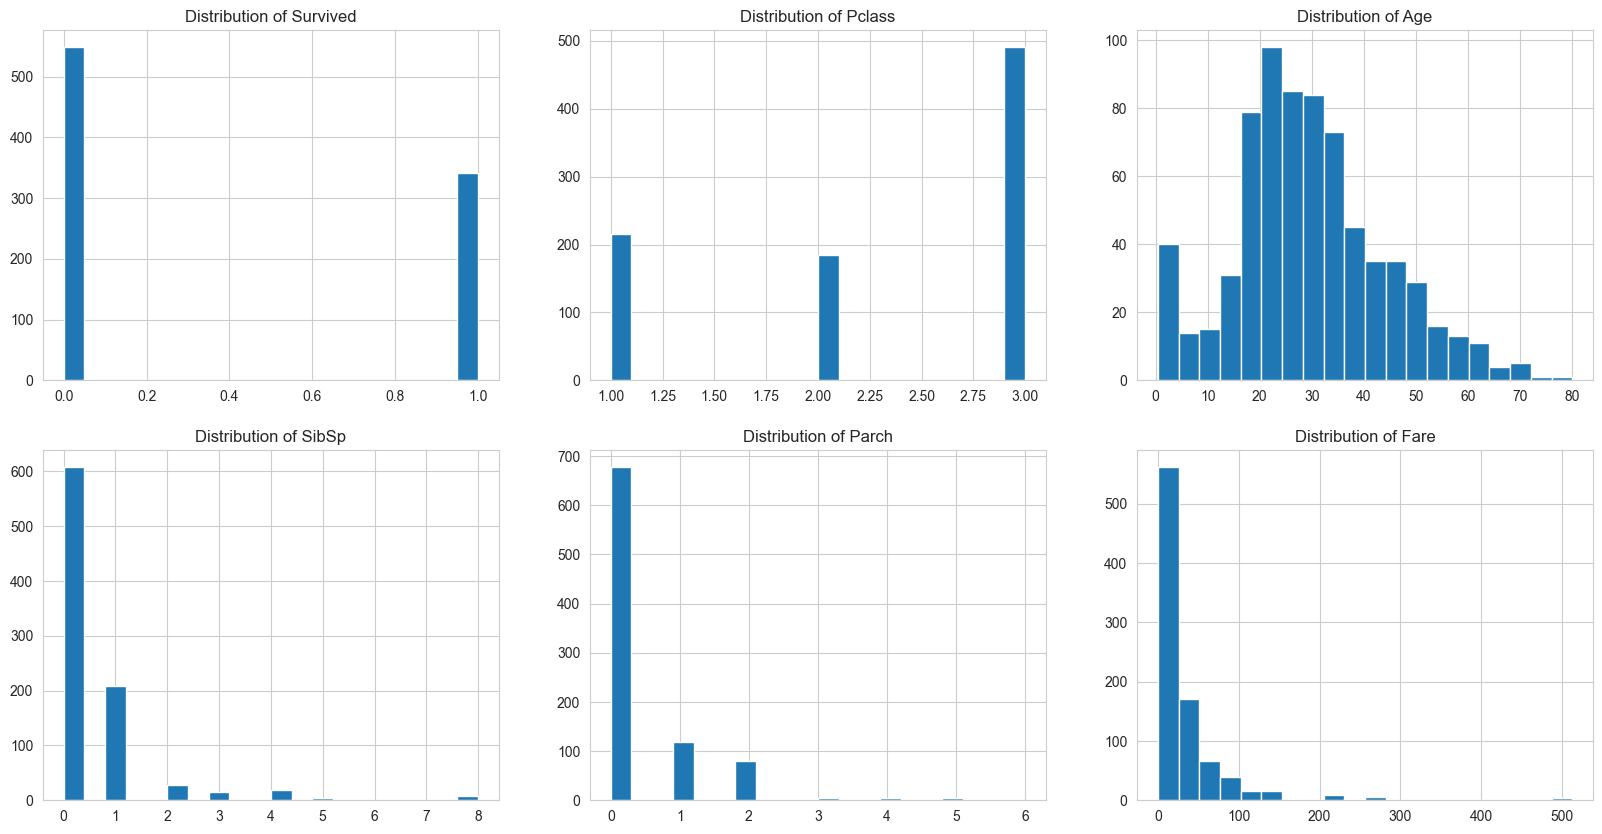

In [10]:
# Display the distribution of numerical features
# Specify the style of the plots
sns.set_style("whitegrid")
visualizer.display_multiple_distribution_subplots(numerical_features, plot_type="hist", bins=20)

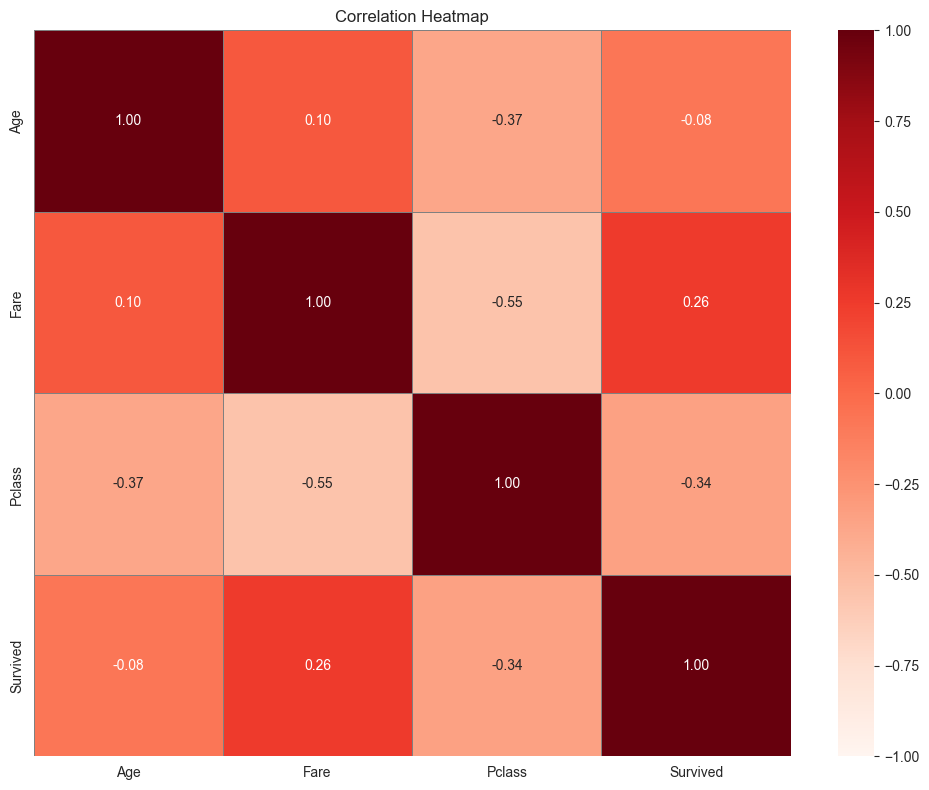

In [11]:
# Display the correlation between 'Age', 'Fare', 'Pclass', and 'Survived'
visualizer.display_correlation(columns=["Age", "Fare", "Pclass", "Survived"])

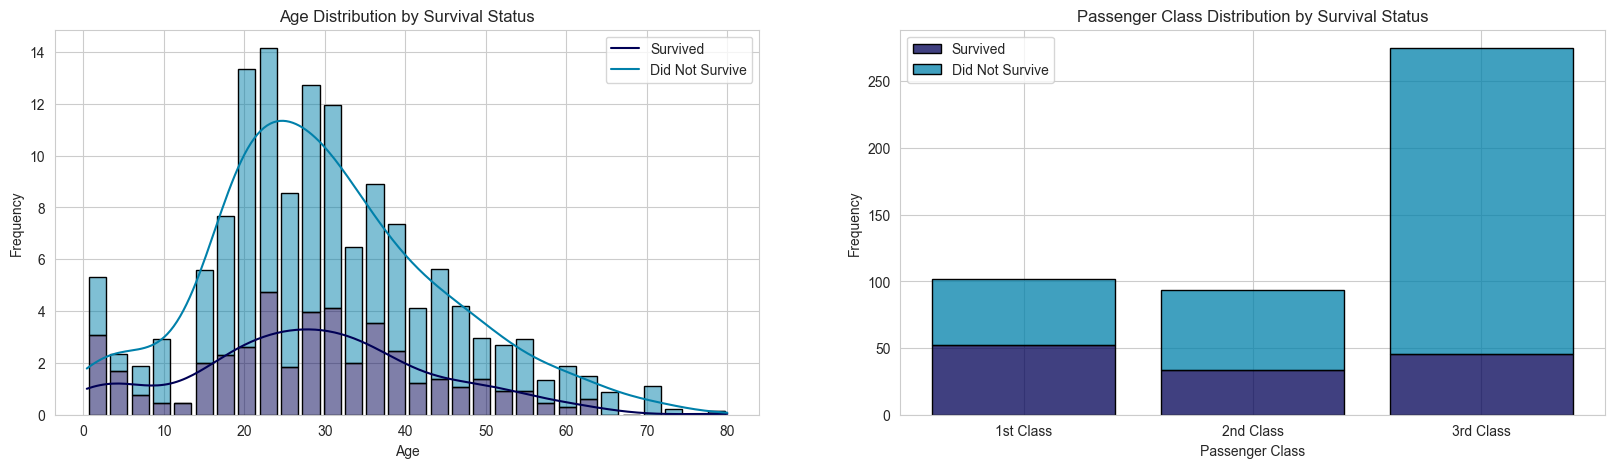

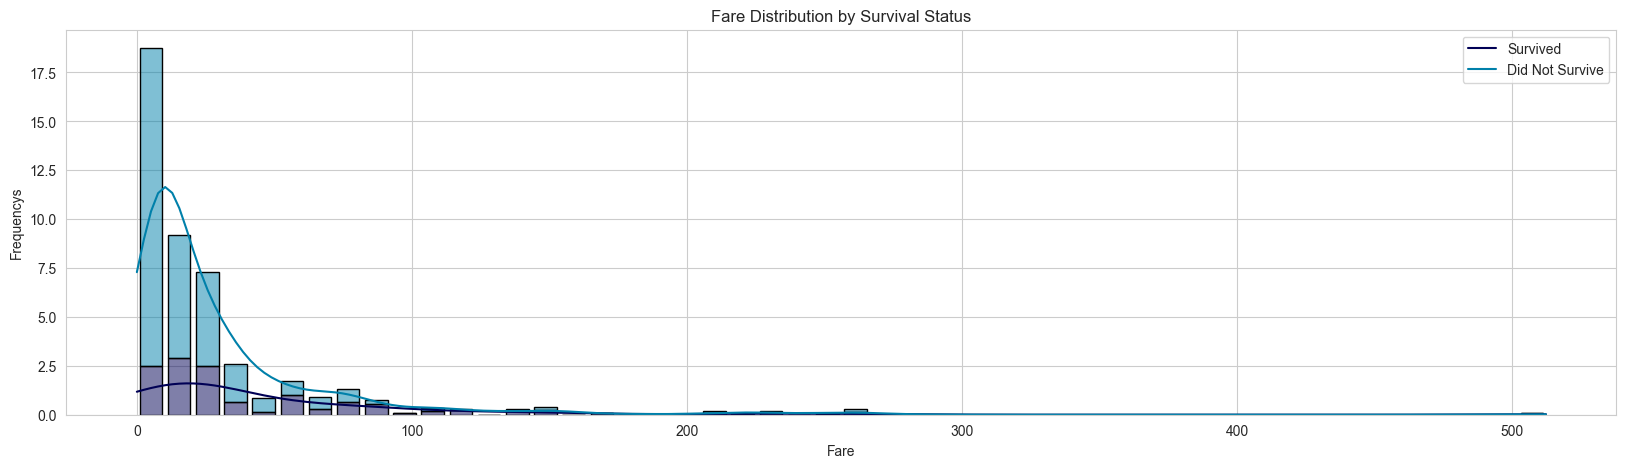

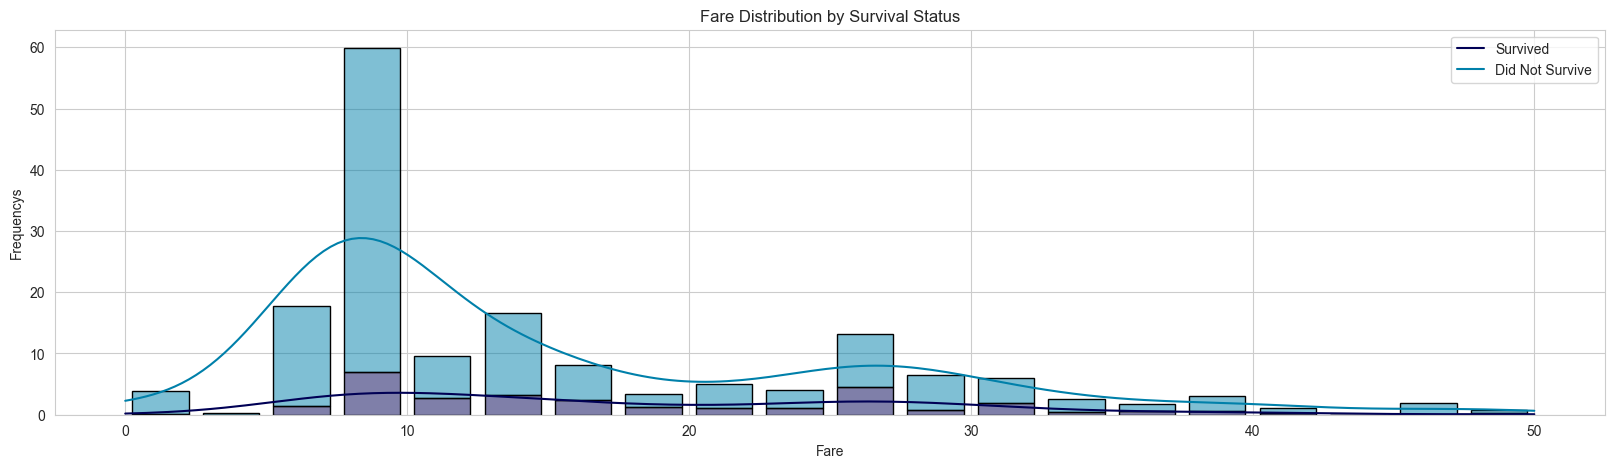

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(x="Pclass", hue="Survived", data=titanic_df, multiple="stack", stat="frequency", discrete=True, shrink=0.8, palette="ocean_r", edgecolor="black", ax=axs[1])
axs[1].set_title("Passenger Class Distribution by Survival Status")
axs[1].set_xlabel("Passenger Class")
axs[1].set_ylabel("Frequency")
axs[1].set_xticks([1, 2, 3])
axs[1].set_xticklabels(["1st Class", "2nd Class", "3rd Class"])
axs[1].legend(["Survived", "Did Not Survive"])

sns.histplot(x="Age", hue="Survived", data=titanic_df, multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black", ax=axs[0], bins=30, kde=True)
axs[0].set_title("Age Distribution by Survival Status")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Frequency")
axs[0].legend(["Survived", "Did Not Survive"])

fig2 = plt.figure(figsize=(20, 5))
sns.histplot(x="Fare", hue="Survived", data=titanic_df, multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black", kde=True, bins=50)
plt.title("Fare Distribution by Survival Status")
plt.xlabel("Fare")
plt.ylabel("Frequencys")
plt.legend(["Survived", "Did Not Survive"])

fig3 = plt.figure(figsize=(20, 5))
sns.histplot(x="Fare", hue="Survived", data=titanic_df[titanic_df['Fare'] <= 50], multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black", kde=True, bins=20)
plt.title("Fare Distribution by Survival Status")
plt.xlabel("Fare")
plt.ylabel("Frequencys")
plt.legend(["Survived", "Did Not Survive"])

#### The Age Feature

Text(0, 0.5, 'Frequency')

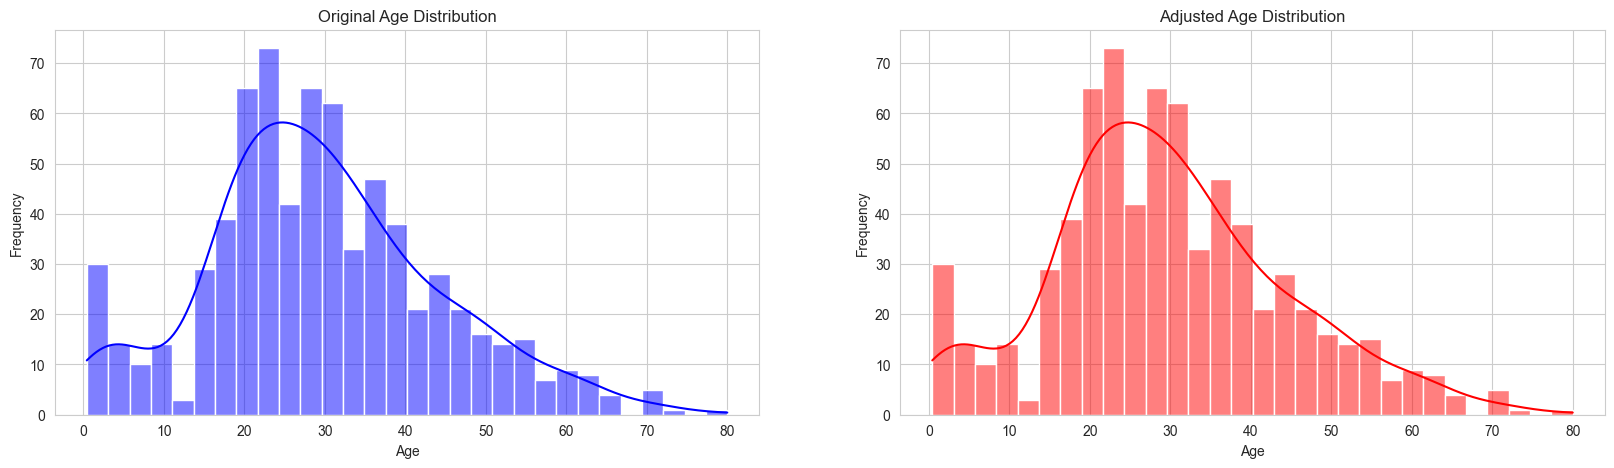

In [13]:
# Create an adjuted age column that fills missing values with the median age
filled_age_feature = missing_value_handler.fill_missing_values_by_feature("Age", "median", return_column=True)

# Display the distribution of the adjusted age column alongside the distribution of the original age column
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.histplot(titanic_df["Age"], bins=30, kde=True, color="blue", ax=axs[0])
axs[0].set_title("Original Age Distribution")
axs[0].set_xlabel("Age")
axs[0].set_ylabel("Frequency")

sns.histplot(filled_age_feature, bins=30, kde=True, color="red", ax=axs[1])
axs[1].set_title("Adjusted Age Distribution")
axs[1].set_xlabel("Age")
axs[1].set_ylabel("Frequency")

<Axes: xlabel='Age', ylabel='Frequency'>

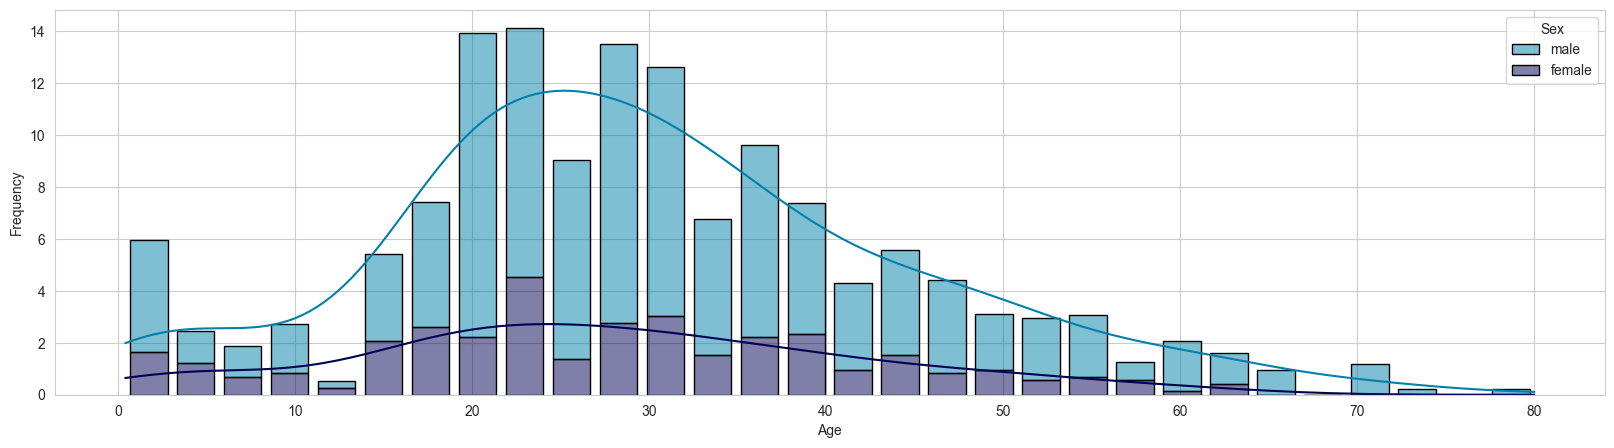

In [14]:
# Display the disribution of the filled 'Age' column by 'gender'
fig = plt.figure(figsize=(20, 5))
sns.histplot(x=filled_age_feature, hue=titanic_df['Sex'], multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black", kde=True, bins=30)

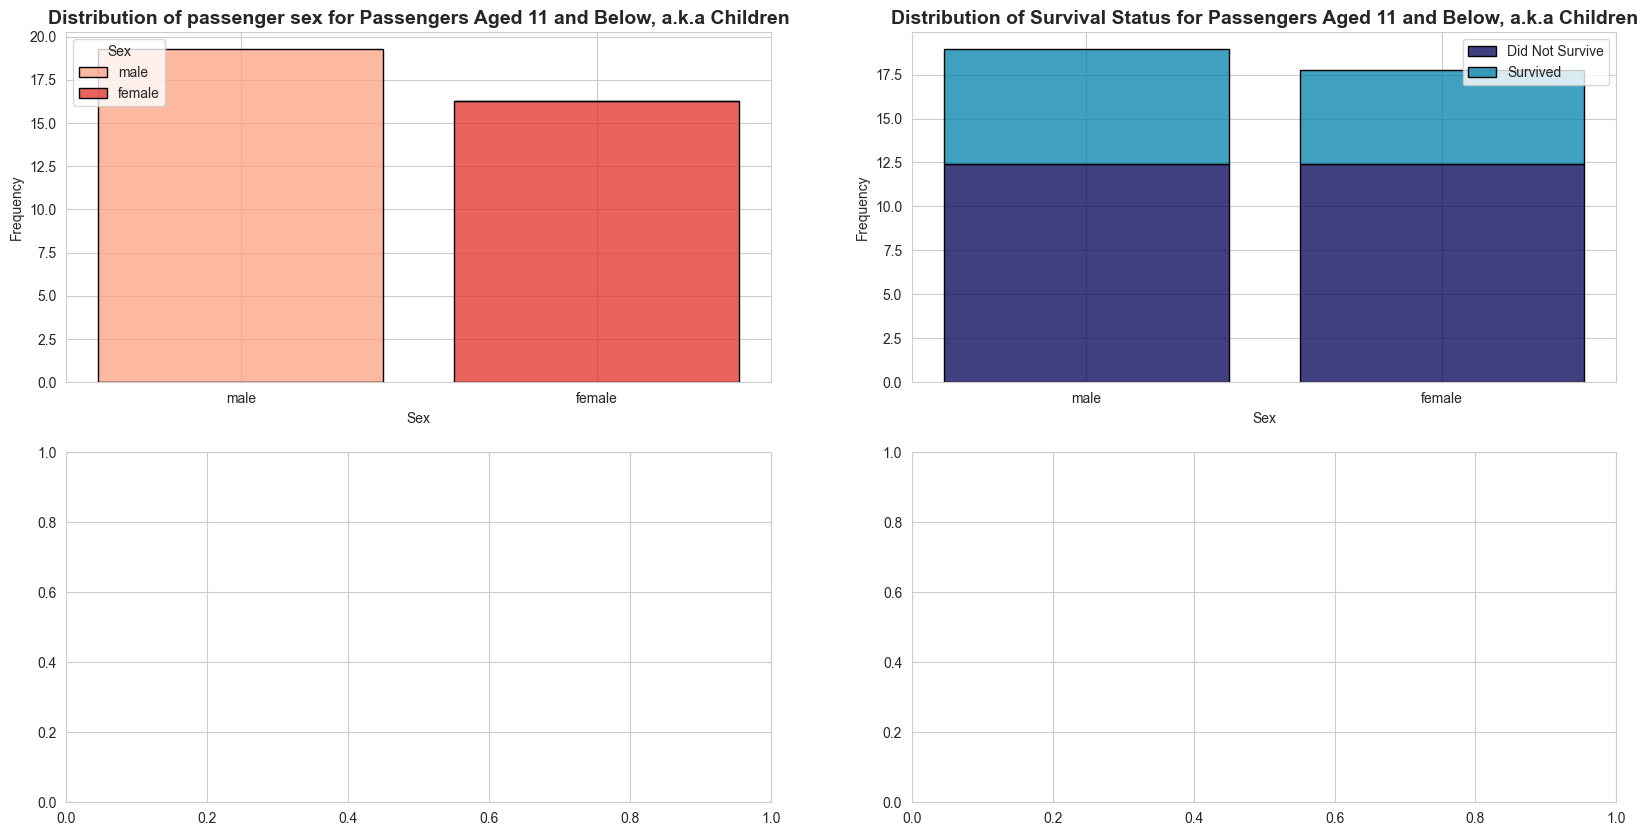

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
sns.histplot(x='Sex', data=titanic_df[titanic_df['Age'] <= 13], hue='Sex', ax=axs[0, 0], multiple="stack", stat="frequency", shrink=0.8, edgecolor="black", palette="Reds")
axs[0, 0].set_title('Distribution of passenger sex for Passengers Aged 11 and Below, a.k.a Children', fontsize=14, fontweight='bold')

sns.histplot(x='Sex', data=titanic_df[titanic_df['Age'] <= 13], hue='Survived', ax=axs[0, 1], multiple="stack", stat="frequency", shrink=0.8, edgecolor="black", palette="ocean_r")
axs[0, 1].set_title('Distribution of Survival Status for Passengers Aged 11 and Below, a.k.a Children', fontsize=14, fontweight='bold')
axs[0, 1].legend(["Did Not Survive", "Survived"])

#### Passenger Class

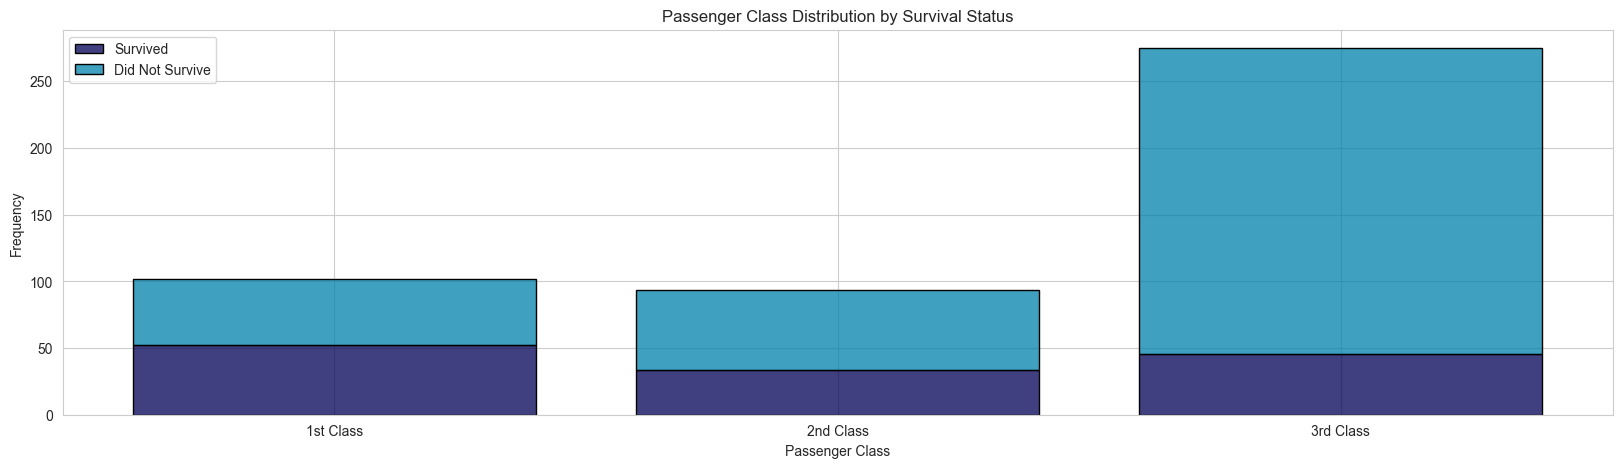

In [16]:
# Display the distribution of the 'Pclass' feature by 'Survived' status
fig = plt.figure(figsize=(20, 5))
sns.histplot(x="Pclass", hue="Survived", data=titanic_df, multiple="stack", stat="frequency", discrete=True, shrink=0.8, palette="ocean_r", edgecolor="black")
plt.title("Passenger Class Distribution by Survival Status")
plt.xlabel("Passenger Class")
plt.ylabel("Frequency")
plt.xticks([1, 2, 3], ["1st Class", "2nd Class", "3rd Class"])
plt.legend(["Survived", "Did Not Survive"])

<Axes: xlabel='Pclass', ylabel='Age'>

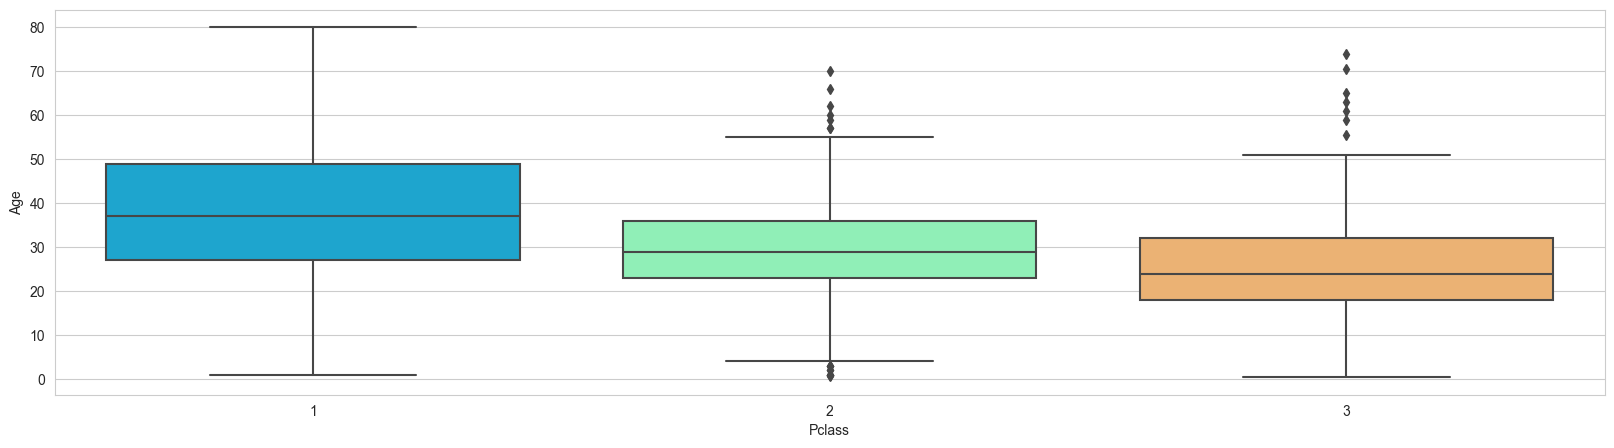

In [17]:
# Show a boxplot for each of the classes in the 'Pclass' feature by 'Age'
fig = plt.figure(figsize=(20, 5))
sns.boxplot(x="Pclass", y="Age", data=titanic_df, palette="rainbow")

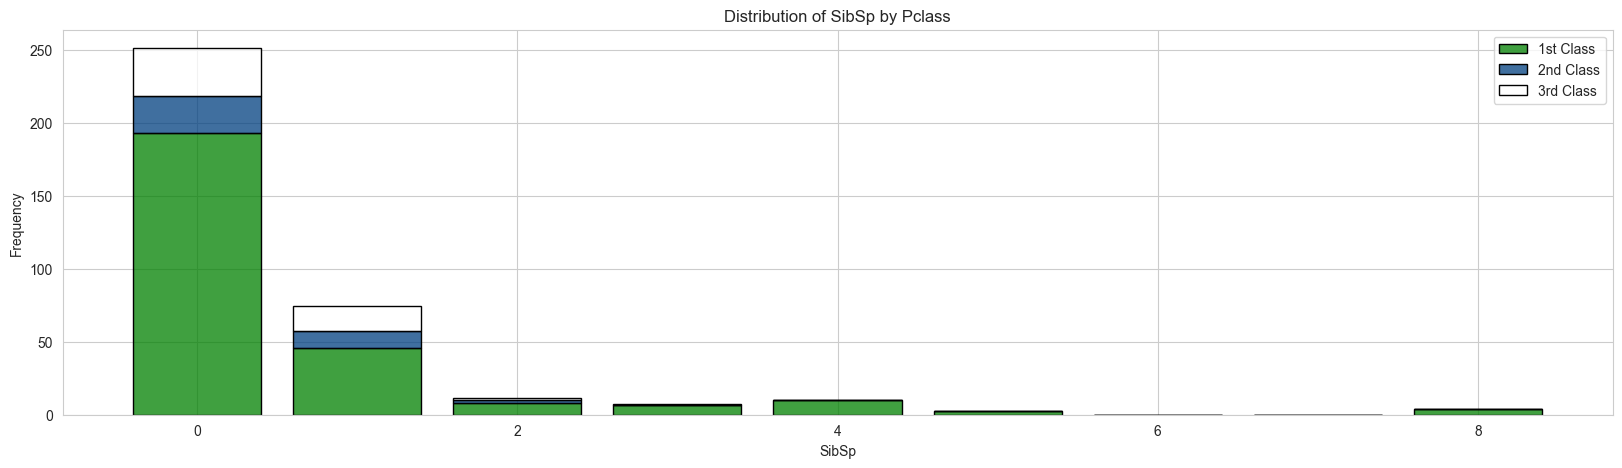

In [18]:
# Distribution of 'SibSp' by 'Pclass'
fig = plt.figure(figsize=(20, 5))
sns.histplot(x="SibSp", hue="Pclass", data=titanic_df, multiple="stack", stat="frequency", discrete=True, shrink=0.8, palette="ocean_r", edgecolor="black")
plt.title("Distribution of SibSp by Pclass")
plt.xlabel("SibSp")
plt.ylabel("Frequency")
plt.legend(["1st Class", "2nd Class", "3rd Class"])

#### Passenger Names

In [19]:
# Extract the last name from the 'Name' column
titanic_df['Last Name'] = titanic_df['Name'].apply(lambda x: x.split(',')[0])
print(titanic_df['Last Name'].head())
print()
print(titanic_df['Last Name'].value_counts())
print()

# Extract the title from the 'Name' column
titanic_df['Title'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
print(titanic_df['Title'].value_counts())

# Extract the husband's name from the 'Name' column for women who are married based on the title
titanic_df['Husband Name'] = titanic_df['Name'].apply(lambda x: x.split(',')[1].split('.')[1].strip() if 'Mrs' in x else None)
titanic_df['Husband Name'] = titanic_df['Husband Name'].apply(lambda x: x.split('(')[0].strip() if x and '(' in x else x)
titanic_df['Husband Name'].value_counts()

0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
4        Allen
Name: Last Name, dtype: object

Last Name
Andersson    9
Sage         7
Panula       6
Skoog        6
Carter       6
            ..
Hanna        1
Lewy         1
Mineff       1
Haas         1
Dooley       1
Name: count, Length: 667, dtype: int64

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64


Husband Name
                    15
William              5
Thomas               3
Joseph               3
Samuel               2
                    ..
Frederic Oakley      1
Sinai                1
Victor de Satode     1
Dickinson H          1
Thomas Jr            1
Name: count, Length: 104, dtype: int64

#### Marital Status

In [20]:
# Create a class that would determine if the passenger has a wife or husband on board
class MaritalStatus:
    def __init__(self, df: pd.DataFrame):
        self.df = df
    
    def create_marital_status_feature(self):
        # Define the 'Marital Status' column with a default value of 'Single'
        self.df['Marital Status'] = 'Single'
    
    def get_meriatal_status(self):
        # Check if the passenger is a woman and has the title 'Mrs'
        # If so, return 'Married', otherwise return 'Single'
        self.df.loc[self.df['Title'] == 'Mrs', 'Marital Status'] = 'Married'
        mask_has_husband_on_board = (self.df['SibSp'] > 0) & (self.df['Title'] == 'Mrs')
        self.df.loc[mask_has_husband_on_board, 'Marital Status'] = 'Married with Spouse on Board'
                
        # Check if the passenger has a wife on board via the 'SibSp' column and the 'Last Name' column. Check if that person is a 'Mrs' and has the same last name.
        # If the man's title is 'Mr.', return 'Married', otherwise return 'Single'
        mask_has_wife = (self.df['SibSp'] > 0) & (self.df['Title'] == 'Mr') & (self.df['Last Name'].isin(self.df[self.df['Title'] == 'Mrs']['Last Name'].values))
        self.df.loc[mask_has_wife, 'Marital Status'] = 'Married with Spouse on Board'
    
    def return_df(self):
        return self.df

In [21]:
marital_status = MaritalStatus(titanic_df)

marital_status.create_marital_status_feature()

marital_status.get_meriatal_status()

titanic_df_with_marital_status = marital_status.return_df()

titanic_df_with_marital_status['Marital Status'].value_counts()

Marital Status
Single                          715
Married with Spouse on Board    131
Married                          45
Name: count, dtype: int64

In [22]:
titanic_df['SibSp'].value_counts()

SibSp
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64

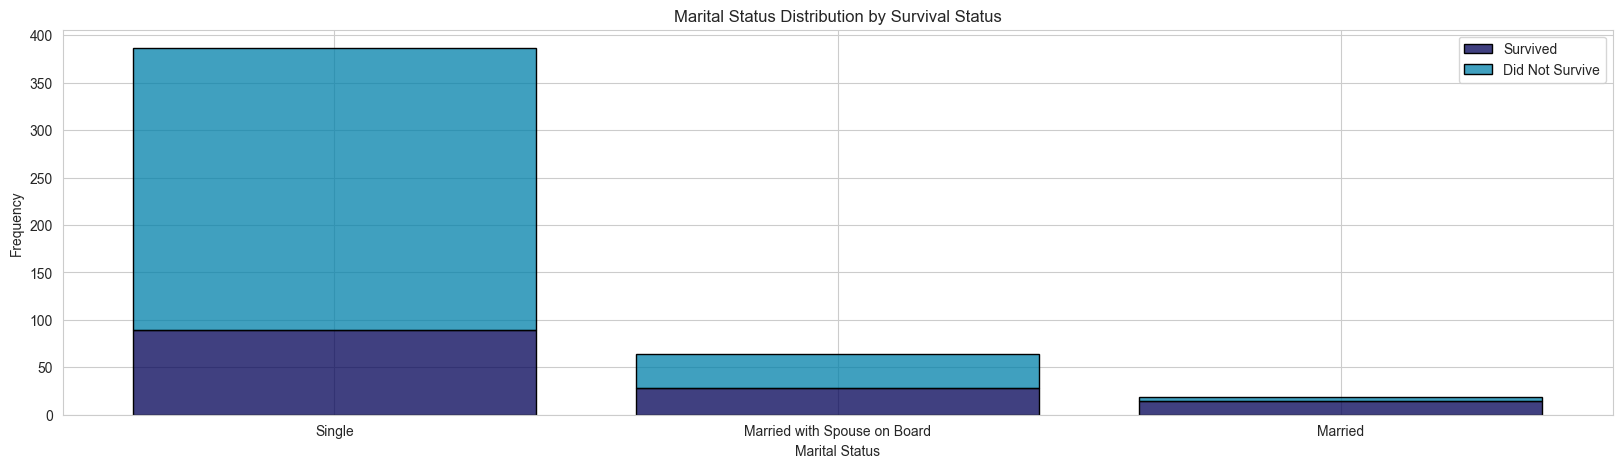

In [23]:
# Display the relationship between 'Marital Status' and 'Survived'
fig = plt.figure(figsize=(20, 5))
sns.histplot(x="Marital Status", hue="Survived", data=titanic_df, multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black")
plt.title("Marital Status Distribution by Survival Status")
plt.xlabel("Marital Status")
plt.ylabel("Frequency")
plt.legend(["Survived", "Did Not Survive"])

<function matplotlib.pyplot.legend(*args, **kwargs)>

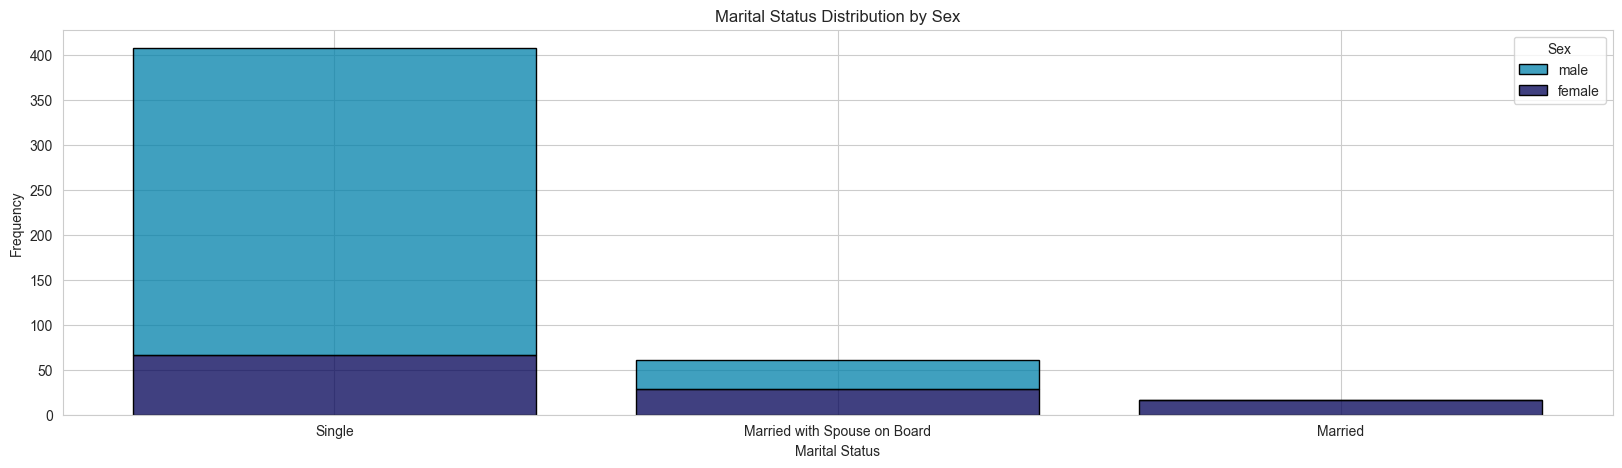

In [24]:
# Display the distribution of 'Marital Status' by 'Sex'
fig = plt.figure(figsize=(20, 5))
sns.histplot(x="Marital Status", hue='Sex', data=titanic_df, multiple="stack", stat="frequency", shrink=0.8, palette="ocean_r", edgecolor="black")
plt.title("Marital Status Distribution by Sex")
plt.xlabel("Marital Status")
plt.ylabel("Frequency")
plt.legend

#### Siblings

In [25]:
titanic_df['Siblings'] = 0

titanic_df.loc[titanic_df['Marital Status'] == 'Married with Spouse on Board', 'Siblings'] = titanic_df['SibSp'] - 1

titanic_df.loc[(titanic_df['Marital Status'] == 'Single') | (titanic_df['Marital Status'] == 'Married'), 'Siblings'] = titanic_df['SibSp']

titanic_df['Siblings'].value_counts()

Siblings
0    729
1     93
2     25
4     17
3     16
8      7
5      4
Name: count, dtype: int64

#### Adults and Children

In [26]:
# Create a column called 'Age Group' that groups the passengers into age groups
titanic_df['Age Group'] = pd.cut(titanic_df['Age'], bins=[0, 14, 19, 30, 40, 50, 60, 100], labels=['0-13', '14-18', '19-29', '30-39', '40-49', '50-59', '60+'])
titanic_df['Age Group'].value_counts()

Age Group
19-29    245
30-39    155
14-18     87
40-49     86
0-13      77
50-59     42
60+       22
Name: count, dtype: int64

In [27]:
# Display the relationship between 'Age Group' and 'Survived' status by passenger sex
titanic_df_grouped = titanic_df.groupby(['Age Group', 'Survived', 'Sex']).size()
titanic_df_grouped

C:\Users\jorda\AppData\Local\Temp\ipykernel_34016\1749340515.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic_df_grouped = titanic_df.groupby(['Age Group', 'Survived', 'Sex']).size()


Age Group  Survived  Sex   
0-13       0         female     14
                     male       18
           1         female     24
                     male       21
14-18      0         female      8
                     male       45
           1         female     29
                     male        5
19-29      0         female     22
                     male      136
           1         female     61
                     male       26
30-39      0         female      9
                     male       77
           1         female     46
                     male       23
40-49      0         female     10
                     male       43
           1         female     21
                     male       12
50-59      0         female      1
                     male       24
           1         female     13
                     male        4
60+        0         female      0
                     male       17
           1         female      3
                     male  

In [28]:
titanic_df['Sex'].value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

<function matplotlib.pyplot.legend(*args, **kwargs)>

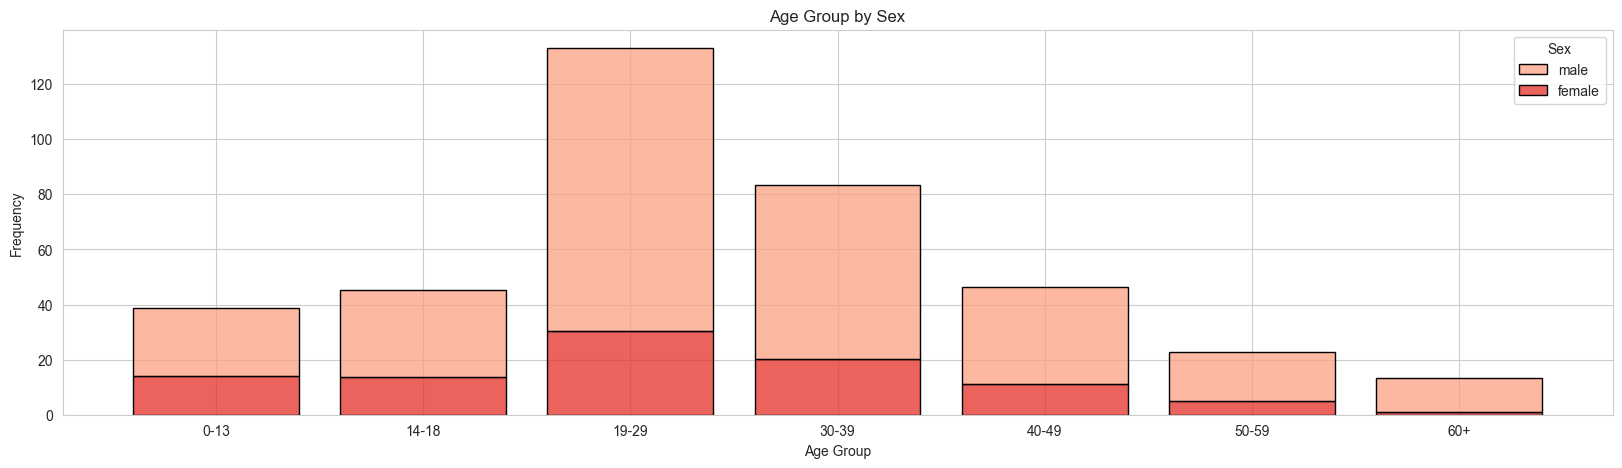

In [29]:
# Display the relationship between 'Age Group' and 'Sex'
fig = plt.figure(figsize=(20, 5))
sns.histplot(x="Age Group", data=titanic_df, hue='Sex', multiple="stack", stat="frequency", shrink=0.8, palette="Reds", edgecolor="black")
plt.title("Age Group by Sex")
plt.xlabel("Age Group")
plt.ylabel("Frequency")
plt.legend

In [30]:
# Create an 'Age Group' column that groups the passengers into age groups
titanic_df['Age Group'] = pd.cut(titanic_df['Age'], bins=[0, 14, 19, 30, 40, 50, 60, 100], labels=['0-13', '14-18', '19-29', '30-39', '40-49', '50-59', '60+'])
titanic_df['Age Group'].value_counts()

Age Group
19-29    245
30-39    155
14-18     87
40-49     86
0-13      77
50-59     42
60+       22
Name: count, dtype: int64

In [33]:
# Group 'Age Group' by 'Sex'
titanic_df_grouped_by_sex = titanic_df.groupby(['Sex'])['Age Group'].value_counts().fillna(0)
titanic_df_grouped_by_sex

Sex     Age Group
female  19-29         83
        30-39         55
        0-13          38
        14-18         37
        40-49         31
        50-59         14
        60+            3
male    19-29        162
        30-39        100
        40-49         55
        14-18         50
        0-13          39
        50-59         28
        60+           19
Name: count, dtype: int64

#### Preliminary Interpretation